# Audio Composition Analyser using Tensorflow
C S Sahil 19BCE2094 , Anmol Bhardwaj 19BCE0675

In [1]:
import os
import json
import numpy as np
import librosa
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import tensorflow as tf

In [2]:
# Dataset location
SOURCE_PATH = 'data/'

# Path to labels and processed data file, json format.
JSON_PATH = 'data.json'

# Sampling rate.
sr = 22050

TOTAL_SAMPLES = 29 * sr
 
# X amount of slices => X times more training examples.
NUM_SLICES = 10
SAMPLES_PER_SLICE = int(TOTAL_SAMPLES / NUM_SLICES)

In [3]:
def preprocess_data(source_path, json_path):

    mydict = {
        "labels": [],
        "mfcc": []
        }

    for i, (dirpath, dirnames, filenames) in enumerate(os.walk(source_path)):

        for file in filenames:
            song, sr = librosa.load(os.path.join(dirpath, file), duration=29)

            for s in range(NUM_SLICES):
                start_sample = SAMPLES_PER_SLICE * s
                end_sample = start_sample + SAMPLES_PER_SLICE
                mfcc = librosa.feature.mfcc(y=song[start_sample:end_sample], sr=sr, n_mfcc=13)
                mfcc = mfcc.T
                mydict["labels"].append(i-1)
                mydict["mfcc"].append(mfcc.tolist())
    
    with open(json_path, 'w') as f:
        json.dump(mydict, f)
    f.close()

In [4]:
def load_data(json_path):

    with open(json_path, 'r') as f:
        data = json.load(f)
    f.close()

    # numpy arrays for TensorFlow compatibility.
    X = np.array(data["mfcc"])
    y = np.array(data["labels"])

    return X, y

In [5]:
def prepare_datasets(inputs, targets, split_size):
    
    # Creating a validation set and a test set.
    inputs_train, inputs_val, targets_train, targets_val = train_test_split(inputs, targets, test_size=split_size)
    inputs_train, inputs_test, targets_train, targets_test = train_test_split(inputs_train, targets_train, test_size=split_size)
    
    # Our CNN model expects 3D input shape.
    inputs_train = inputs_train[..., np.newaxis]
    inputs_val = inputs_val[..., np.newaxis]
    inputs_test = inputs_test[..., np.newaxis]
    
    return inputs_train, inputs_val, inputs_test, targets_train, targets_val, targets_test

In [6]:
def design_model(input_shape):

    #  model architecture.
    model = tf.keras.models.Sequential([
        
        tf.keras.layers.Conv2D(32, (3,3), activation='relu', input_shape=input_shape),
        tf.keras.layers.MaxPooling2D((3,3), strides=(2,2), padding='same'),
        tf.keras.layers.BatchNormalization(),
        
        tf.keras.layers.Conv2D(32, (3,3), activation='relu'),
        tf.keras.layers.MaxPooling2D((3,3), strides=(2,2), padding='same'),
        tf.keras.layers.BatchNormalization(),
        
        tf.keras.layers.Conv2D(32, (2,2), activation='relu'),
        tf.keras.layers.MaxPooling2D((3,3), strides=(2,2), padding='same'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dropout(0.3),
        
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(64, activation='relu'), 
        tf.keras.layers.Dense(len(np.unique(targets)), activation='softmax')
    ])

    return model

In [7]:
def make_prediction(model, X, y, idx):
    
    genre_dict = {
        0 : "blues",
        1 : "classical",
        2 : "country",
        3 : "disco",
        4 : "hiphop",
        5 : "jazz",
        6 : "metal",
        7 : "pop",
        8 : "reggae",
        9 : "rock",
        }
        
    predictions = model.predict(X)
    genre = np.argmax(predictions[idx])
    
    print("\n---Now testing the model for one audio file---\nThe chosen song genre(PREDICTION)is: {}, and the actually the genre was: {}.\n".format(genre_dict[genre], genre_dict[y[idx]]))

In [8]:
def plot_performance(hist):
    
    acc = hist.history['acc']
    val_acc = hist.history['val_acc']
    loss = hist.history['loss']
    val_loss = hist.history['val_loss']

    epochs = range(len(acc))

    plt.plot(epochs, acc, 'r', label='Training accuracy')
    plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
    plt.title('Training and validation accuracy')
    plt.legend()
    plt.figure()

    plt.plot(epochs, loss, 'r', label='Training Loss')
    plt.plot(epochs, val_loss, 'b', label='Validation Loss')
    plt.title('Training and validation loss')
    plt.legend()

    plt.show()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_6 (Conv2D)           (None, 123, 11, 32)       320       
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 62, 6, 32)        0         
 2D)                                                             
                                                                 
 batch_normalization_6 (Batc  (None, 62, 6, 32)        128       
 hNormalization)                                                 
                                                                 
 conv2d_7 (Conv2D)           (None, 60, 4, 32)         9248      
                                                                 
 max_pooling2d_7 (MaxPooling  (None, 30, 2, 32)        0         
 2D)                                                             
                                                      

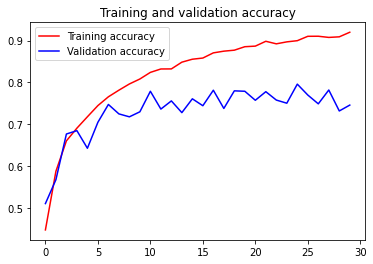

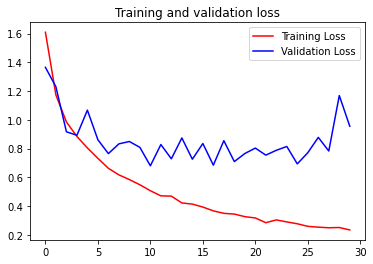


---Now testing the model for one audio file---
The chosen song genre(PREDICTION)is: rock, and the actually the genre was: rock.



In [11]:
if __name__ == "__main__":

    preprocess_data(source_path=SOURCE_PATH, json_path=JSON_PATH)
    
    inputs, targets = load_data(json_path=JSON_PATH)
    
    Xtrain, Xval, Xtest, ytrain, yval, ytest = prepare_datasets(inputs, targets, 0.2)

    input_shape = (Xtrain.shape[1], Xtrain.shape[2], 1)
    model = design_model(input_shape)

    # Selection of the optimizer, loss type and metrics for performance evaluation.
    model.compile(optimizer = tf.keras.optimizers.RMSprop(lr=0.001),
                     loss='sparse_categorical_crossentropy',
                     metrics = ['acc']
                     )

    model.summary()

    #Training the model.
    history = model.fit(Xtrain, ytrain,
                        validation_data=(Xval, yval),
                        epochs=30,
                        batch_size=32
                        )

    plot_performance(history)

    # Testing the model on never seen before data.
    make_prediction(model, Xtest, ytest, 24)
